# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [143]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

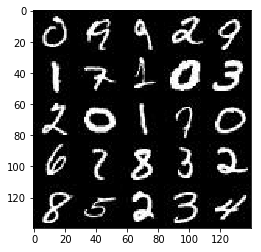

In [144]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [145]:
mnist_images.shape

(25, 28, 28, 1)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

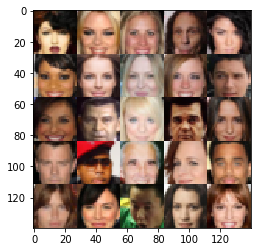

In [146]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [147]:
mnist_images.shape

(25, 28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [148]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [149]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    learn_rate = tf.placeholder(tf.float32, ())

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [179]:
def discriminator(images, reuse=False, alpha=0.2, training=True):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # NOTES: was 3 -> 256 -> 512 -> 1024 
    
    filter_size = 5 # use 4 or 5? was 2
    
    def relu(x, alpha=alpha):
        return tf.maximum(alpha * x, x)

    
    with tf.variable_scope('discriminator', reuse=reuse):

        # input is 28x28x3?
        # Input Layer - Conv1
        conv1 = tf.layers.conv2d(images, 64, filter_size, strides=(2,2), padding='same')
        conv1 = relu(conv1)
        # output is now 14x14x256

        # Conv2
        conv2 = tf.layers.conv2d(conv1, 128, filter_size, strides=(2,2), padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=training)
        conv2 = relu(conv2)
        # output is now 7x7x512
        
        # Conv3
        conv3 = tf.layers.conv2d(conv2, 256, filter_size, strides=(2,2), padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=training)
        conv3 = relu(conv3)
        # output is now 4x4x1024
        
        # NOTES: had three layers in previous DCGAN

        # Fully Connected Layer
        fc = tf.reshape(conv3, [-1, 4*4*256])
        fc = tf.layers.dense(fc, 1, activation=None)
        # output is now 1

        logits = fc
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [196]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # NOTES: was 1024 -> 512 -> 256 -> out_channel_dim
    
    filter_size = 5 # use 4 or 5? (was 2)
    
    alpha=0.2
    training=is_train
    reuse=not is_train
    
    def relu(x, alpha=0.2):
        return tf.maximum(alpha * x, x)
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        fc = tf.layers.dense(z, 2*2*256, activation=None)
        
        # Reshape to start CNN stack
        fc = tf.reshape(fc, [-1, 2, 2, 256])
        fc = tf.layers.batch_normalization(fc, training=training)
        fc = relu(fc)
        # output is now 2x2x1024    
        
        # Convt1
        convt1 = tf.layers.conv2d_transpose(fc, 128, filter_size, strides=(2,2), padding='valid')
        convt1 = tf.layers.batch_normalization(convt1, training=training)
        convt1 = relu(convt1)
        # output is now 7x7x512
        
        # Convt2
        convt2 = tf.layers.conv2d_transpose(convt1, 64, filter_size, strides=(2,2), padding='same')
        convt2 = tf.layers.batch_normalization(convt2, training=training)
        convt2 = relu(convt2)
        # output is now 14x14x256
        
        # Convt3
        convt3 = tf.layers.conv2d_transpose(convt2, out_channel_dim, filter_size, strides=(2,2), padding='same')
        # output is now 28x28xout_channel_dim
        
        # Logits
        logits = convt3

        # Output Layer
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [197]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1 # was 0.1
    
    g_out = generator(input_z, out_channel_dim, is_train=True)

    d_real_out, d_real_logits = discriminator(input_real, reuse=False, training=True)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True, training=True)
    
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
        labels=tf.ones_like(d_real_logits) * (1 - smooth), logits=d_real_logits))

    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
        labels=tf.zeros_like(d_fake_logits), logits=d_fake_logits))
    
    d_loss = d_fake_loss + d_real_loss
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
        labels=tf.ones_like(d_fake_logits), logits=d_fake_logits)) 
    


    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [198]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()

    g_vars = [g_var for g_var in t_vars if g_var.name.startswith('generator')]
    d_vars = [d_var for d_var in t_vars if d_var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [199]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [200]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # generate placeholders
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # create loss function
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # create optimization functions
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples = []
    losses = []
    steps = 0
    
    print_every=10
    show_every=100

    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                
                # rescale images from (-0.5, .5) to (-1.0, 1.0)
                batch_images = batch_images * 2
                
                steps += 1
                
                # sample random noise for generator
                batch_z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))
                
                # run optimizers
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [201]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

In [202]:
mnist_dataset.shape

(60000, 28, 28, 1)

In [203]:
mnist_dataset.image_mode

'L'

Epoch 1/2... Discriminator Loss: 5.4477... Generator Loss: 13.9251
Epoch 1/2... Discriminator Loss: 2.8841... Generator Loss: 0.1400
Epoch 1/2... Discriminator Loss: 1.6315... Generator Loss: 0.4186
Epoch 1/2... Discriminator Loss: 1.6692... Generator Loss: 0.3484
Epoch 1/2... Discriminator Loss: 1.6349... Generator Loss: 0.3566
Epoch 1/2... Discriminator Loss: 2.1140... Generator Loss: 0.2192
Epoch 1/2... Discriminator Loss: 1.5925... Generator Loss: 0.4506
Epoch 1/2... Discriminator Loss: 1.6357... Generator Loss: 0.3910
Epoch 1/2... Discriminator Loss: 1.5131... Generator Loss: 0.4582
Epoch 1/2... Discriminator Loss: 1.6585... Generator Loss: 0.3763


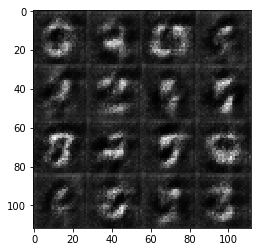

Epoch 1/2... Discriminator Loss: 1.6510... Generator Loss: 0.3983
Epoch 1/2... Discriminator Loss: 1.4924... Generator Loss: 0.4571
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.5105
Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.4830
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.5280
Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 0.4831
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.4959
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.4132
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 1.4460... Generator Loss: 0.4531


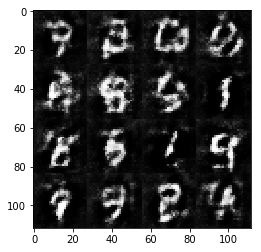

Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.5059
Epoch 1/2... Discriminator Loss: 1.4239... Generator Loss: 0.4669
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.4815
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.5126
Epoch 1/2... Discriminator Loss: 1.4313... Generator Loss: 0.4474
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.4919
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 0.5336
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.4266


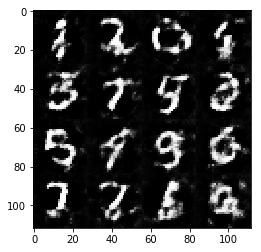

Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 0.5162
Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 0.4091
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 0.6445
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.5099
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.4816
Epoch 1/2... Discriminator Loss: 1.4929... Generator Loss: 0.4165
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.5467
Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 0.4349


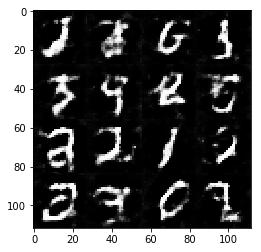

Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.6143
Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 0.3981
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.5586
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.5010
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.4995
Epoch 1/2... Discriminator Loss: 1.6044... Generator Loss: 0.3776
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.5229
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.4936
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.5265
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.4986


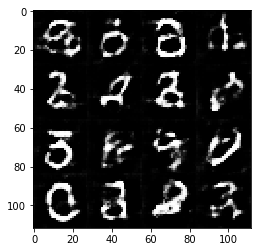

Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 0.5027
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.5060
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.5561
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.4990
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.5446
Epoch 2/2... Discriminator Loss: 1.6991... Generator Loss: 0.3128
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.4897
Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.5292
Epoch 2/2... Discriminator Loss: 1.4460... Generator Loss: 0.4431


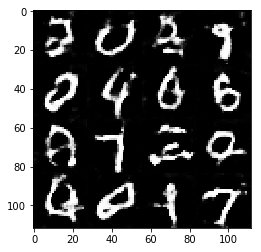

Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 1.4659... Generator Loss: 0.5158
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.5313
Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.6499
Epoch 2/2... Discriminator Loss: 1.6974... Generator Loss: 0.3440
Epoch 2/2... Discriminator Loss: 1.3292... Generator Loss: 0.5193
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.5064
Epoch 2/2... Discriminator Loss: 1.4731... Generator Loss: 0.4397
Epoch 2/2... Discriminator Loss: 1.3217... Generator Loss: 0.5302
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.5531


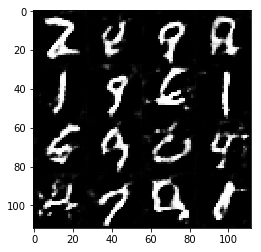

Epoch 2/2... Discriminator Loss: 1.2916... Generator Loss: 0.5759
Epoch 2/2... Discriminator Loss: 1.2205... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.4459
Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.5478
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.4913
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.5323
Epoch 2/2... Discriminator Loss: 1.4214... Generator Loss: 0.4988
Epoch 2/2... Discriminator Loss: 1.4472... Generator Loss: 0.4544
Epoch 2/2... Discriminator Loss: 1.4822... Generator Loss: 0.4224
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.5527


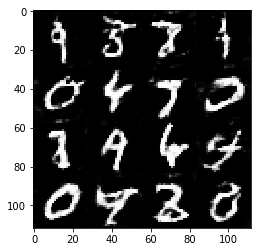

Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.5856
Epoch 2/2... Discriminator Loss: 1.5258... Generator Loss: 0.4266
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.5945
Epoch 2/2... Discriminator Loss: 1.8888... Generator Loss: 2.6135
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 1.5344
Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 1.5527
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 1.3909
Epoch 2/2... Discriminator Loss: 1.5112... Generator Loss: 2.1039
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 1.6574
Epoch 2/2... Discriminator Loss: 1.5057... Generator Loss: 1.8631


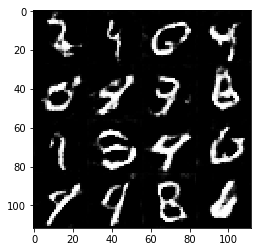

Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 1.4963
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 1.5104
Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 1.1372


In [210]:
batch_size = 128 # was 128 
z_dim = 100
learning_rate = 0.001 # was 0.0002
beta1 = 0.1 # was 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [211]:
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

In [212]:
celeba_dataset.shape

(202599, 28, 28, 3)

In [213]:
celeba_dataset.image_mode

'RGB'

Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.8989... Generator Loss: 0.3223
Epoch 1/1... Discriminator Loss: 2.2699... Generator Loss: 12.3706
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 8.4341
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 5.9377
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 2.3273
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 2.5256
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 2.8597
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 3.1207


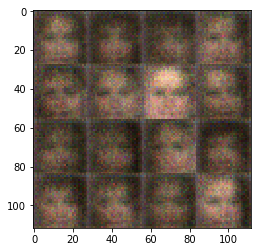

Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 2.8297
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 3.5492
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 3.2783
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 2.7236
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 2.3525
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 2.9737
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 2.4069
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 2.8513
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 3.2094
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.5194


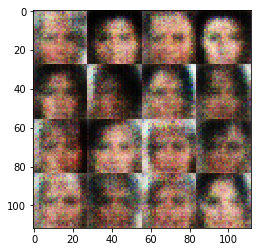

Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.4569
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.7457
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 2.5220
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 3.1167
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.0757


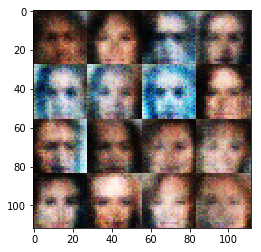

Epoch 1/1... Discriminator Loss: 1.8328... Generator Loss: 3.6353
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.3734
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.5618
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 2.6207
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 2.9798
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 2.1409
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.9585


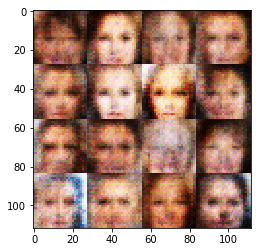

Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.9201
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 2.3495
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.6628
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.7038
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 2.1431
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 1.9208
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.4838
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 2.2339
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.8338
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.9466


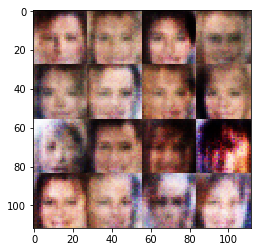

Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.6431
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.7394
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.8778
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.6740
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.6357
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 2.0284
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 1.9551
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.7176
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 1.8312


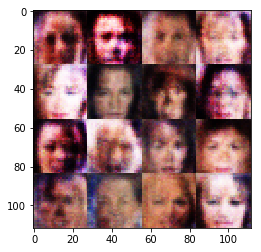

Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.5767
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.9656
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.7651
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.6816
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 2.2852
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.8173
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.9867
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.7963
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.9376


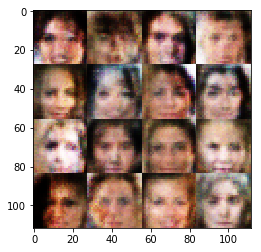

Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 2.4408
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 1.3334
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.6275


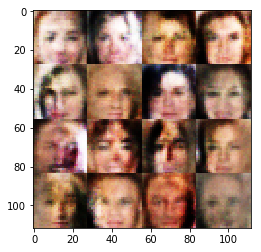

Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.8283
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.6932
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.7792
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.8292
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 2.2996
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.5148


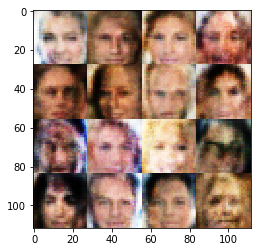

Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 2.0562
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.5578
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 2.2013
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.8836
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.7541
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 0.9387


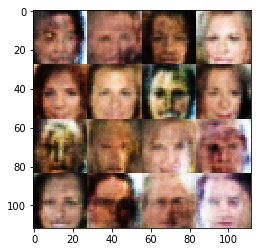

Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.2292
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.6034


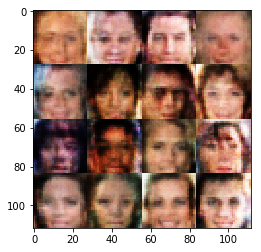

Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.4238
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 2.6125
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.4518


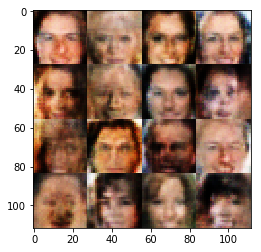

Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 2.0072
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 2.0229
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.9841
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.4222
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.6340... Generator Loss: 0.3640
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.6409


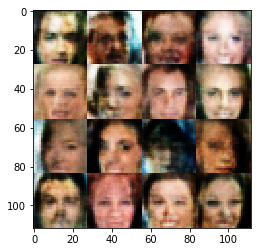

Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.6457... Generator Loss: 0.3404
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 2.7078
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 1.9796


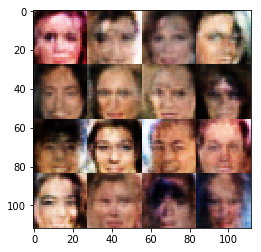

Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.4395
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 1.8652
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 2.5597
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 2.1675
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 2.1722
Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 2.0665
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.5234
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.4325


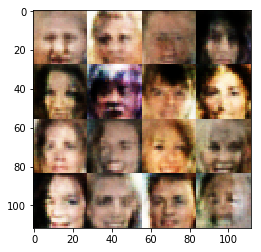

Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 2.2812
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 2.2106
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.4579
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 2.0386... Generator Loss: 0.2328


In [214]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1 # was 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.